In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.optimize import minimize
from ellipse import LsqEllipse

from numba import njit

In [2]:
import pickle as pkl
def unpack(file_path, is_number, freq_var=0):
    with open(file_path, 'rb') as file:
        row_data = pkl.load(file)
#         print(row_data.keys())
        if is_number:
            freq_vars = row_data[0]
            power = np.array(row_data[1])
            freq = np.array(row_data[2][freq_vars[freq_var]][0][0])
            data = np.array([row_data[2][freq_vars[freq_var]][i][1]
                                 for i in range(len(power))])
        else:
            try:
                freq, power = row_data['Frequency [Hz]'], row_data['power [dBm]']
                data = np.array(row_data['data'])
            except:
                freq, power = row_data['Frequency [Hz]'], row_data['Power [dBm]']
                data = np.array(row_data['data'])
            
    return power, data, freq

In [3]:
class Parameters(object):
    
    def __init__(self, a=1., alpha=1., tau=1., phi=1., gamma1=1., gamma2=1., freq_r=None, omega=None, n=1):
        self.a, self.alpha, self.tau, self.phi, self.gamma1, self.gamma2,  self.freq_r, self.omega =\
        a, alpha, tau, phi, gamma1, gamma2, freq_r, omega
        
        if (freq_r == None): self.freq_r = np.ones(shape=n)
        if (omega == None): self.omega = np.ones(shape=n)
            
    def get_parameters(self):
        return self.a, self.alpha, self.tau, self.phi, self.gamma1, self.gamma2,  self.freq_r, self.omega 

In [127]:
class Initial_Guess(object):
    
    def __init__(self, a=None, alpha=None, tau=None, phi=None, gamma1=None, gamma2=None, freq_r=None, omega=None, n=1):
        self.a, self.alpha, self.tau, self.phi, self.gamma1, self.gamma2,  self.freq_r, self.omega =\
        a, alpha, tau, phi, gamma1, gamma2, freq_r, omega
        
        if (freq_r == None): self.freq_r = np.ones(shape=n)
        if (a == None): self.a = np.ones(shape=n)
        if (alpha == None): self.alpha = np.ones(shape=n)
        if (tau == None): self.tau = np.ones(shape=n)
        if (phi == None): self.phi = np.ones(shape=n)
        if (gamma1 == None): self.gamma1 = np.ones(shape=n)
        if (gamma2 == None): self.gamma2 = np.ones(shape=n)
        if (omega == None): self.omega = np.ones(shape=n)
        self.HW_abs_ids = np.zeros(shape=(n, 2))
        self.FW_abs_ids = np.zeros(shape=(n, 2))
        self.HWHM_abs = np.ones(shape=n)
        
        
    def find_HW_ids(self, y):
        HM = (max(y) + min(y))/2
        index_left, index_right = np.argmin(y), np.argmin(y)
        while (y[index_left] < HM and index_left > 0): index_left -= 1
        while (y[index_right] < HM and index_right < len(y) - 1): index_right += 1
        return np.array([index_left, index_right])
    
    def get_HW_abs_ids(self, y, cut=-1):
        ids = self.find_HW_ids(y)
        self.HW_abs_ids[cut] = ids
        return ids
    
    def get_FW_abs_ids(self, y, cut=-1):
        ids = self.find_HW_ids(y)
        delta = ids[1] - ids[0]
        ids = np.array([ids[0] - 3*delta//2, ids[1] + 3*delta//2])
        #ids = [ids[0] - delta, ids[1] + delta]
        if ids[0] < 0: ids[0] = 0
        if ids[1] >= len(y): ids[1] = len(y) - 1
        self.FW_abs_ids[cut] = ids
        return ids
    
    def get_HWHM_abs(self, x, y, cut=-1):
        idx_l, idx_r = self.get_HW_abs_ids(y, cut=cut)
        hwhm = (x[idx_r] - x[idx_l])/2
        self.HWHM_abs[cut] = hwhm
#         plt.scatter(x[idx_l], y[idx_l])
#         plt.scatter(x[idx_r], y[idx_r])
        return hwhm

    def get_parameters(self):
        return self.a, self.alpha, self.tau, self.phi, self.gamma1, self.gamma2,  self.freq_r, self.omega 

In [30]:
class S21_transmission(object):

    def __init__(self, power, data, freq):
        self.power, self.data, self.freq = np.array(power), np.array(data), np.array(freq)
        
        n = len(power)
        
        self.real, self.imag = np.real(self.data), np.imag(self.data)
        self.abs = np.abs(self.data)
        self.arg = np.unwrap(np.angle(self.data))
        
        self.params = Parameters(n=n)
        self.ig = Initial_Guess(n=n)
        self.update_initial_guess()
        
    def update_data(self):
        self.real, self.imag = np.real(self.data), np.imag(self.data)
        self.abs = np.abs(self.data)
        self.arg = np.unwrap(np.angle(self.data))
        
        
    def update_initial_guess(self):
        for cut in range(len(self.power)):
            x, y = self.freq, self.abs[cut]
            _ = self.ig.get_HW_abs_ids(y, cut=cut)
            _ = self.ig.get_FW_abs_ids(y, cut=cut)
            _ = self.ig.get_HWHM_abs(x, y, cut=cut)
        
        
    def fit_abs(self, cut=-1, is_plot=False):
        x, y = self.freq, self.abs[cut]
        if is_plot: plt.plot(x, y)

        def  Lorentzian(x, x_0, alpha, gamma, y_0, k):
            return k*x + y_0 + (alpha/(gamma*np.pi)) * (1/(((x - x_0)/gamma)**2 + 1))
        hwhm = self.ig.get_HWHM_abs(x, y, cut=cut)
        p0 = [x[np.argmin(y)], (max(y) - min(y))*np.pi*hwhm, hwhm, max(y), 0.]
        popt, pcov = curve_fit(Lorentzian, x, y, p0 = p0, maxfev=100000)
        #if is_plot: plt.plot(x, Lorentzian(x, *popt), label='Lorentzian')
        
        def Abs(freq, freq_r, phi, gamma1, gamma2, a, rabi_freq):
            t = (freq_r - freq)/gamma2
            r = ((gamma1/(2*gamma2))*1/((1 + t**2 + rabi_freq**2/(gamma1*gamma2))))
            return a*np.sqrt(1 - 2*r*(np.cos(phi) - t*np.sin(phi)) + (r**2)*(1 + t**2))
        freq_r, alpha, gamma, a = popt[0], popt[1], popt[2], popt[3]
        ids = np.arange(0, len(self.freq))
        #ids = np.arange(0, self.ig.get_FW_abs_ids(y)[1])
        ids = np.arange(*self.ig.get_FW_abs_ids(y))
        #if is_plot: plt.plot(x[ids], y[ids])
        p0 = [freq_r, 0., 2*gamma, gamma, a, gamma]
        popt, pcov = curve_fit(Abs, x, y, p0=p0, maxfev=100000)
        if is_plot: plt.plot(x, Abs(x, *popt), label='S_21')
        
        #if is_plot: plt.legend()
          
        return popt, pcov
    
    def fit_arg(self, cut=-1, is_plot=False):
        x, y = self.freq, self.arg[cut]
        if is_plot: plt.plot(x, y)
        
        def linear(x, a, b): return a*x + b
        popt, pcov = curve_fit(linear, x, y)
            
        def Arg(freq, freq_r, phi, gamma1, gamma2, alpha, rabi_freq, tau):
            t = (freq_r - freq) / gamma2
            r = ((gamma1 / (2 * gamma2)) * 1 / ((1 + t ** 2 + rabi_freq ** 2 / (gamma1 * gamma2))))
            return (alpha + freq*tau + 
                    np.arctan(-(t*np.cos(phi) + np.sin(phi))/(1/r + t*np.sin(phi) - np.cos(phi))))
        tau, alpha = popt[0], popt[1]
        hwhm = self.ig.get_HWHM_abs(self.freq, self.abs[cut], cut=cut)
        freq_r, phi, gamma1, gamma2, rabi_freq = x.mean(), 0., hwhm, hwhm, 1.
        p0 = [freq_r, phi, gamma1, gamma2, alpha, rabi_freq, tau]
        popt, pcov = curve_fit(Arg, x, y, p0=p0, maxfev=100000)
        if is_plot: plt.plot(x, Arg(x, *popt), label='S_21')

        #self.params.tau[cut] = popt[-1]
        
        if is_plot: plt.scatter(freq_r, Arg(freq_r, *popt))
        #if is_plot: plt.legend()
        
        return popt, pcov
    
    def fit_canonical_arg(self, cut=-1, is_plot=False):
        x, y = self.freq, self.arg[cut]
        if is_plot: plt.plot(x, y)
        
        def arg(freq, freq_r, phi, gamma2): return phi + np.arctan((freq_r - freq)/gamma2)
        #ids = np.arange(len(self.freq))
        ids = np.arange(*self.ig.FW_abs_ids[cut], dtype=int)
        if is_plot: plt.plot(x[ids], y[ids])
        p0 = [self.params.freq_r[cut], 0., self.ig.HWHM_abs[cut]]
        popt, pcov = curve_fit(arg, x[ids], y[ids], p0=p0)
        if is_plot: plt.plot(x, arg(x, *popt))
        
        return popt, pcov
    
    def fit_canonical_real(self, cut=-1, is_plot=False):
        def lorentzian(x, freq_r, gamma, R): 
            return gamma/(1 + R + ((freq_r - x)/self.ig.gamma2[cut])**2)
        x, y = self.freq, self.real[cut]
        #t = (self.ig.freq_r[cut] - x)/self.ig.gamma2[cut]
        
        ids = np.arange(*self.ig.FW_abs_ids[cut], dtype=int)
        freq_r0 = self.ig.freq_r[cut]
        R0 = self.ig.HWHM_abs[cut]/self.ig.gamma2[cut]
        gamma0 = max(y)*(1 + R0)
        p0 = [freq_r0, gamma0, R0]
        popt, pcov = curve_fit(lorentzian, x[ids], y[ids], p0=p0)
        gamma, R = popt[1], popt[2]
        
        self.ig.gamma1[cut] = 2*gamma*self.ig.gamma2[cut]
        self.ig.omega[cut] = R*2*gamma*(self.ig.gamma2[cut])**2
        
        if is_plot:
            plt.plot(x, y)
            plt.plot(x[ids], y[ids])
            plt.plot(x, lorentzian(x, *popt))
        
        return popt, pcov
    
    
    def fit_ellipse(self, cut=-1, is_plot=False):
        @njit
        def ellipse(tau, Ax, Ay, phi, a):
            x1, y1 = Ax*(1 + np.cos(tau)), Ay*np.sin(tau)
            z1 = (x1 + 1j*y1)
            z2 = a*(1 - z1*np.exp(1j*phi))
            x, y = np.real(z2), np.imag(z2)
            return x, y

        def error(p, x, y):
            Ax, Ay, phi, a = p
            x0, y0 = a*(1 - Ax*np.cos(phi)), -a*Ax*np.sin(phi)
            err = 0
            for i in range(0, len(x)):
                alpha = np.arctan2((y[i] - y0), (x[i] - x0))
                tau = np.arctan((Ax/Ay)*np.tan(alpha - phi))
                tmp_x, tmp_y = ellipse(tau, Ax, Ay, phi, a)
                alpha_alt = np.arctan2((tmp_y - y0), (tmp_x - x0))
                if np.sign(alpha) != np.sign(alpha_alt): 
                    tau += np.pi
                    tmp_x, tmp_y = ellipse(tau, Ax, Ay, phi, a)
                err += ((tmp_x - x[i])**2 + (tmp_y - y[i])**2)
            return err
        
        def get_ellipse(p, x, y):
            Ax, Ay, phi, a = p
            x0, y0 = a*(1 - Ax*np.cos(phi)), -a*Ax*np.sin(phi)
            ell = []
            for i in range(0, len(x)):
                alpha = np.arctan2((y[i] - y0), (x[i] - x0))
                tau = np.arctan((Ax/Ay)*np.tan(alpha - phi))
                tmp_x, tmp_y = ellipse(tau, Ax, Ay, phi, a)
                alpha_alt = np.arctan2((tmp_y - y0), (tmp_x - x0))
                if np.sign(alpha) != np.sign(alpha_alt):
                    tau += np.pi
                    tmp_x, tmp_y = ellipse(tau, Ax, Ay, phi, a)
                ell.append(tmp_x + 1j*tmp_y)
            return ell


        def fit(x, y):
            data = np.array(list(zip(x, y)))
            reg = LsqEllipse().fit(data)
            center, width, height, phi = reg.as_parameters()

            a0 = abs(center[0] + np.sqrt(height**2 - center[1]**2))
            phi0 = min(abs(phi), abs(np.pi - phi))
            Ax0, Ay0 = abs(width/a0), abs(height/a0)
            p0 = [Ax0, Ay0, phi0, a0]

            res = minimize(error, x0=p0, args=(x, y))
            popt = res.x

            return popt
        
        ids = np.arange(*self.ig.FW_abs_ids[cut], dtype=int)
        x, y = self.real[cut], self.imag[cut]
        popt = fit(x[ids], y[ids])
        baseline_deleted_ellipse = get_ellipse(popt, x, y)
        
        if is_plot:
            plt.axis('equal')
            plt.scatter(x, y, 1)
            plt.scatter(x[ids], y[ids], 1)
            plt.plot(np.real(baseline_deleted_ellipse), np.imag(baseline_deleted_ellipse))
        
        return popt, baseline_deleted_ellipse

    
    def remove_background(self, remove_baseline=False, is_plot=False):
        for cut in range(len(self.power)):
            try:
                popt, pcov = self.fit_abs(cut=cut)
                freq_r = popt[0]

                popt, pcov = self.fit_arg(cut=cut)
                alpha, tau = popt[-3], popt[-1]

                self.data[cut] /= np.exp(1j*alpha)*np.exp(1j*tau*self.freq)
                self.update_data()

                popt, baseline_deleted_ellipse = self.fit_ellipse(cut=cut, is_plot=is_plot)
                if is_plot: plt.show()
                a = popt[3]

                if remove_baseline == True: self.data[cut] = baseline_deleted_ellipse
                self.data[cut] /= a

                self.data[cut] = 1 - self.data[cut]
                self.update_data()

                self.params.freq_r[cut] = freq_r
                self.ig.a[cut] = a
                self.ig.alpha[cut] = alpha
                self.ig.tau[cut] = tau
                
            except: self.data[cut] = np.empty(shape=len(data[cut]))
        self.update_data()
                
    
    def delete_mismatch(self, is_plot=False):
        for cut in range(len(self.power)):
            try:
                popt, pcov = self.fit_canonical_arg(cut=cut, is_plot=is_plot)
                if is_plot: plt.show()
                freq_r, phi, gamma2 = popt[0], popt[1], popt[2]

                self.data[cut] /= np.exp(1j*phi)

                self.ig.freq_r[cut] = freq_r
                self.ig.phi[cut] = phi
                self.ig.gamma2[cut] = gamma2
            except: self.data[cut] = np.empty(shape=len(data[cut]))
        self.update_data()
    
    def get_parameters(self):
        return self.params.get_parameters()

In [31]:
from fit_model import *

In [32]:
def make_baseline(freq=None, eps_baseline=0.1, n=2, delta=30.0e+6):
    n = 2
    
    if freq == None:
        freq = np.linspace(5.126e+09, 5.156e+09, 4501)
    
    baseline_periods = np.random.uniform(0.5*(2*np.pi/delta), (2*np.pi/delta), size=n)
    print(baseline_periods)
    
    baseline = np.array([eps_baseline*np.sin(baseline_periods[i]*freq) for i in range(n)])
    baseline = np.sum(baseline, axis=0)
    
    return baseline

def generate(freq=None, params=None, eps=0.1, eps_baseline=0., is_plot=False, baseline=[]):
    if params == None:
        params = Parameters(a=0.013, alpha=1.6e+3, tau=-3.3e-7, phi=-.5, gamma1=2.6e+6, gamma2=1.3e+6, 
                            freq_r=5.14e+9, omega=0*2.0e+6)
    
    a, alpha, tau, phi, gamma1, gamma2, freq_r, omega = params.get_parameters()
    
    if freq == None:
        freq = np.linspace(5.126e+09, 5.156e+09, 4501)
        #freq = np.linspace(5.106e+09, 5.176e+09, 4501)
        #freq = np.linspace(5.086e+09, 5.196e+09, 4501)
        
    noise = np.random.normal(0, eps, len(freq)) + 1j*np.random.normal(0, eps, len(freq))
    
    if len(baseline)==0: baseline = make_baseline(freq, eps_baseline=eps_baseline)
    
    t = (freq_r - freq)/gamma2
    r = ((gamma1/(2*gamma2))*1/((1 + t**2 + omega**2/(gamma1*gamma2))))
    data = a*np.exp(1j*alpha)*np.exp(1j*freq*tau)*(1 - r*(1 + 1j*t)*np.exp(-1j*phi))
    data += noise
    data *= 1. + baseline
    #data += (0. + baseline)
    
    if is_plot:
        plt.plot(freq, abs(data))
        plt.plot(freq, a*(1. + baseline))
        print(np.std(baseline))
    
    return [0.], [data], freq

In [33]:
path = 'D:/LAQS/One Qubit Fit/2023.02.02/STS_FROM_POWER, 30.11.20_raw_data.pkl'
#path = 'data/VIII_power_two_tone_ro_line_curr0_0001,_vnapower_65dbm_raw_data.pkl'
power, data, freq = unpack(file_path=path, is_number=False)

power, data, freq = unpack(file_path='D:/LAQS/One Qubit Fit/2023.02.02/Al_III_Daria_last_try_5_8_6_3_resonators_on_power.pkl', is_number=True, freq_var=4)
baseline = make_baseline(eps_baseline=0.12)
d = S21_transmission(power, data, freq)
# d = S21_transmission(*generate(eps=0.0002, baseline=baseline, is_plot=True))
n = len(d.power)

[1.60991962e-07 1.53675356e-07]


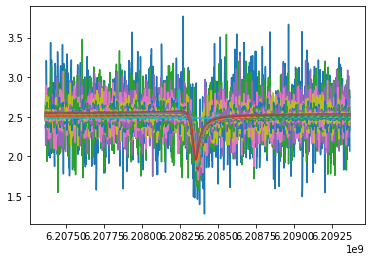

In [34]:
for cut in range(3, n):
    d.fit_abs(cut=cut, is_plot=True)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


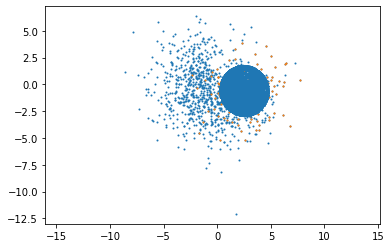

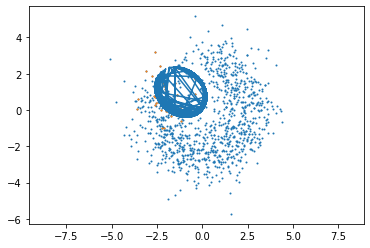

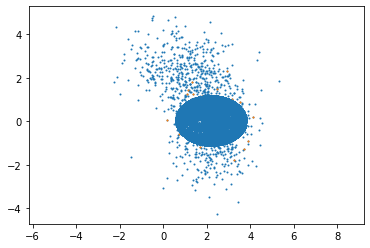

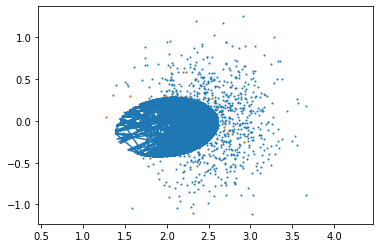

D:\LAQS\One Qubit Fit\2023.02.02\S_21-transmission\fit_model.py:246: RuntimeWarning: invalid value encountered in sqrt
  a0 = abs(center[0] + np.sqrt(height**2 - center[1]**2))


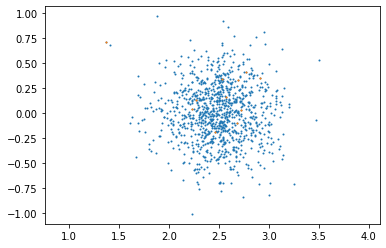

D:\LAQS\One Qubit Fit\2023.02.02\S_21-transmission\fit_model.py:287: RuntimeWarning: invalid value encountered in true_divide
  self.data[cut] /= a
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


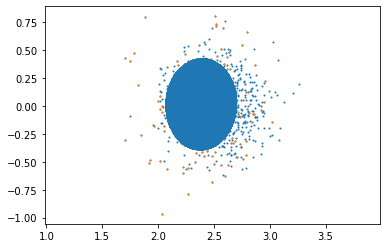

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


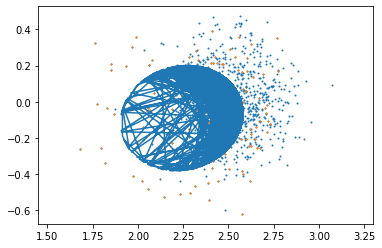

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


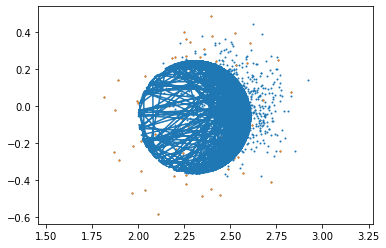

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


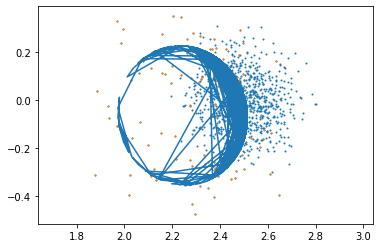

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


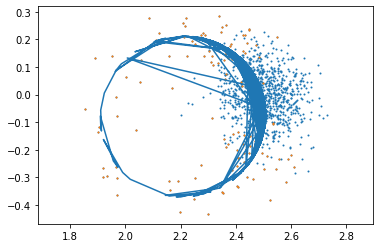

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


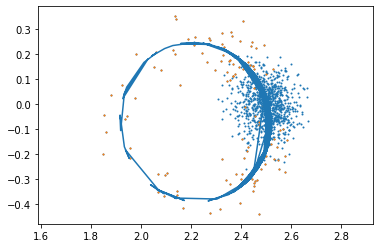

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


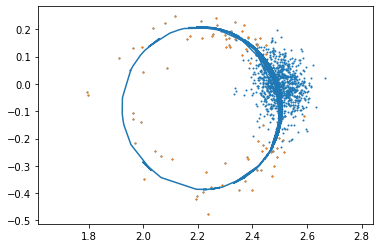

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


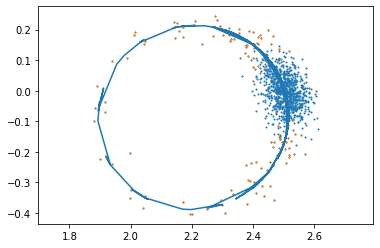

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


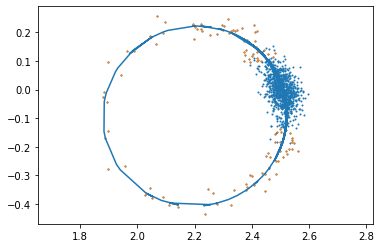

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


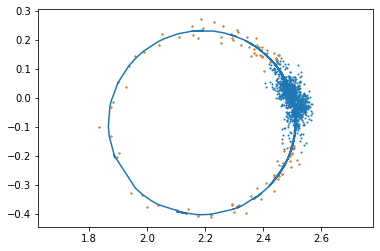

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


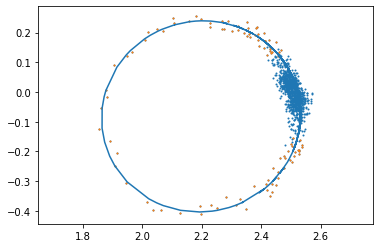

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


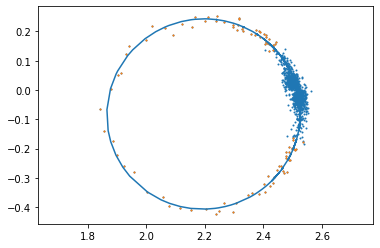

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


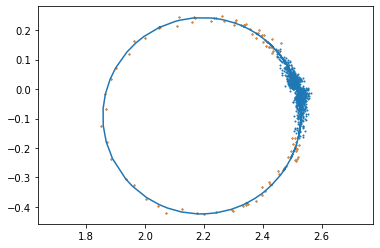

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


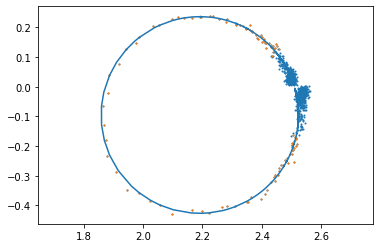

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


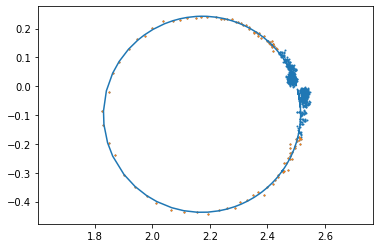

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


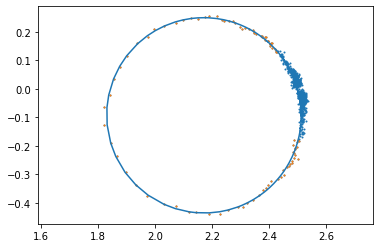

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


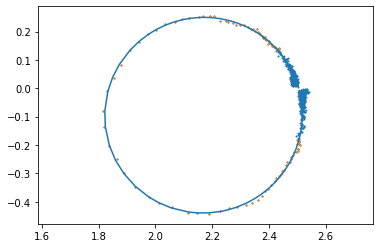

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


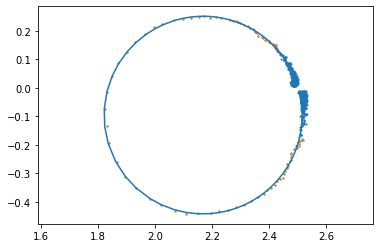

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


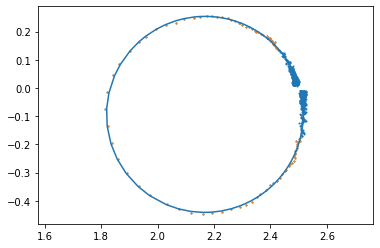

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


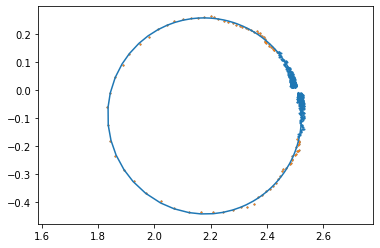

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


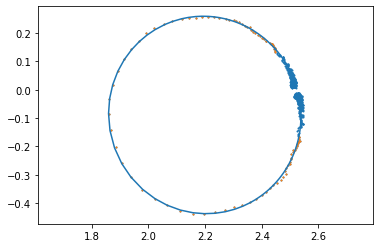

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


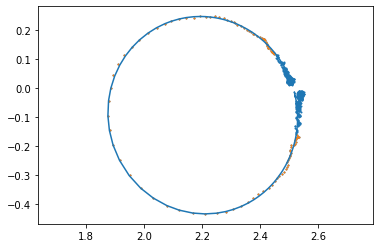

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


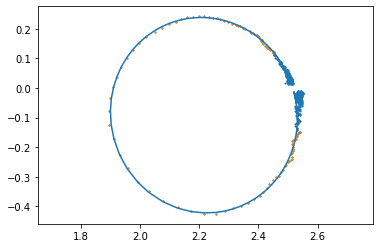

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


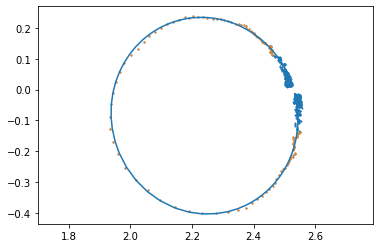

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


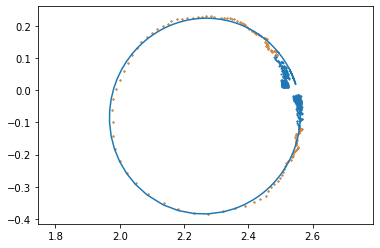

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


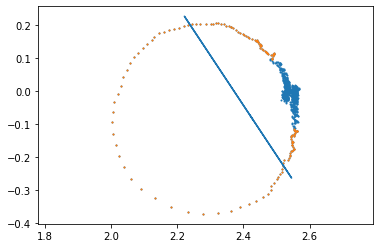

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


In [35]:
d.remove_background(remove_baseline=True, is_plot=True)

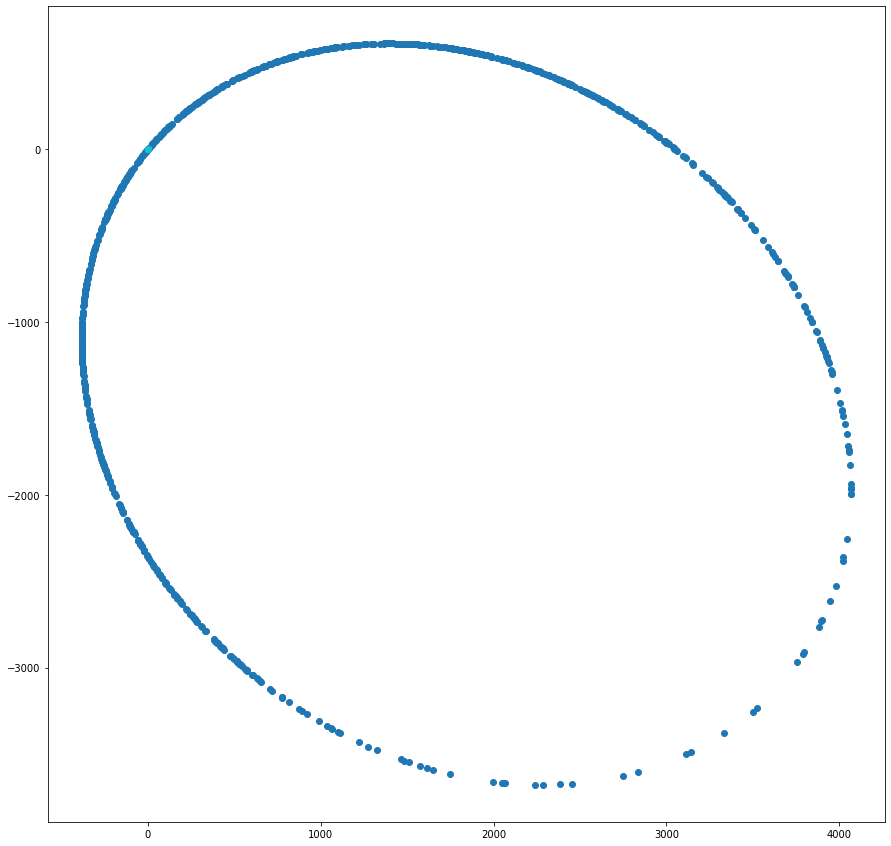

In [36]:
plt.figure(figsize=(15, 15))
plt.axis('equal')
# for cut in range(11, n-2):
for cut in range(1, n):
    plt.scatter(d.real[cut], d.imag[cut])
plt.show()

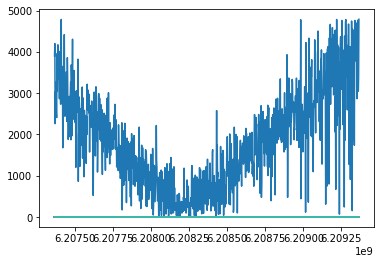

In [37]:
# for cut in range(11, n-2):
for cut in range(1, n):
    plt.plot(d.freq, d.abs[cut])
plt.show()

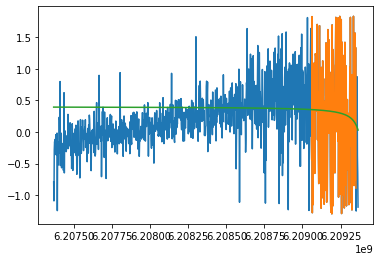

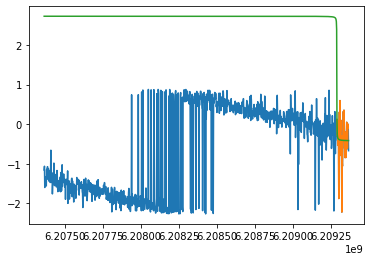

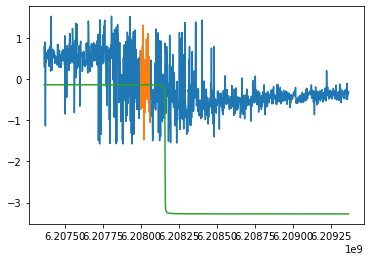

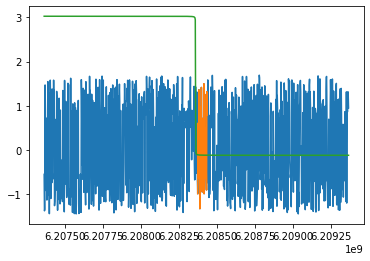

NameError: name 'data' is not defined

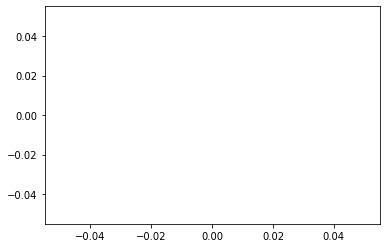

In [38]:
d.delete_mismatch(is_plot=True)

In [ ]:
# for cut in range(11, n-2):
for cut in range(1, n):
    plt.plot(d.freq, d.arg[cut])
plt.show()

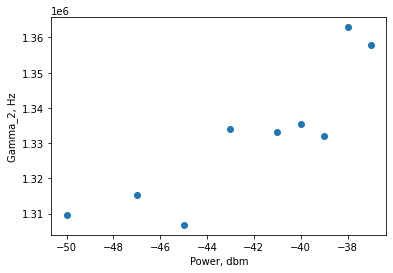

In [15]:
# plt.plot(d.ig.gamma2[11:-2])
plt.xlabel('Power, dbm')
plt.ylabel('Gamma_2, Hz')
plt.scatter(d.power[2:], d.ig.gamma2[2:])

In [16]:
5/131, 25/1310

(0.03816793893129771, 0.019083969465648856)

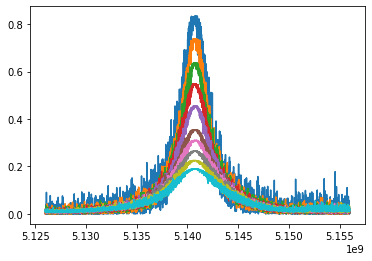

In [17]:
# for cut in range(11, n-2):
for cut in range(1, n):
    plt.plot(d.freq, d.real[cut])
plt.show()

In [18]:
d.fit_canonical_real()

(array([5.14083471e+09, 8.82705956e-01, 3.68888690e+00]),
 array([[ 3.49159379e+07, -5.62192315e-02, -3.53379324e-01],
        [-5.62192315e-02,  1.80973640e-05,  1.15207143e-04],
        [-3.53379324e-01,  1.15207143e-04,  8.03889074e-04]]))

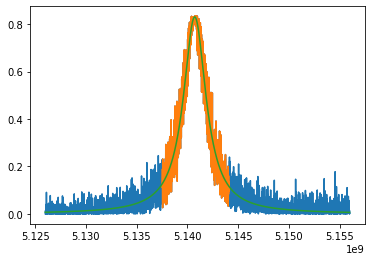

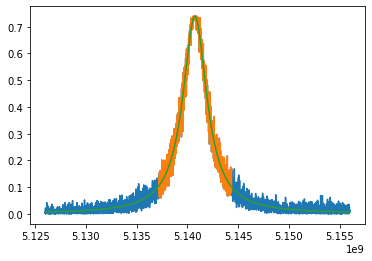

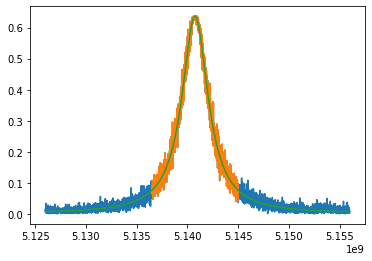

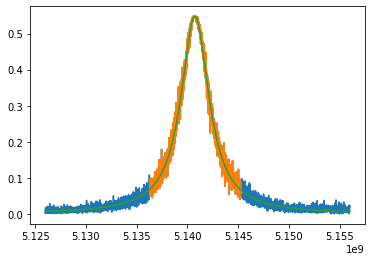

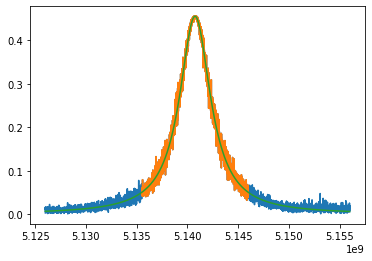

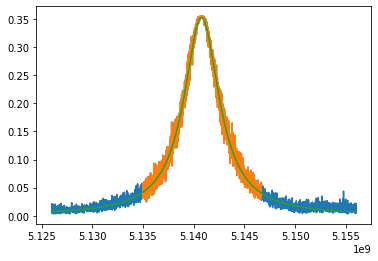

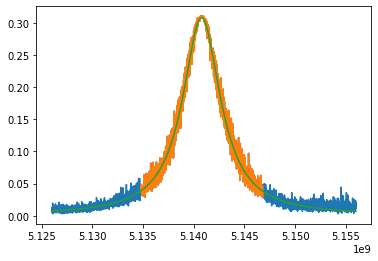

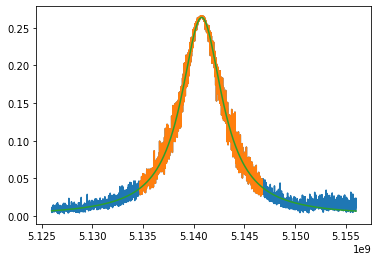

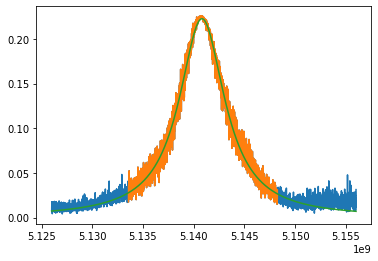

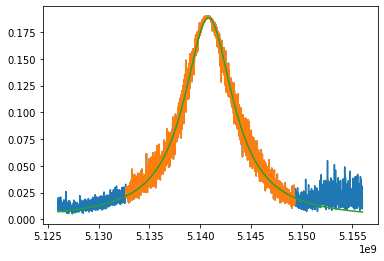

In [19]:
# for cut in range(11, n-2):
for cut in range(1, n):
    d.fit_canonical_real(cut=cut, is_plot=True)
    plt.show()

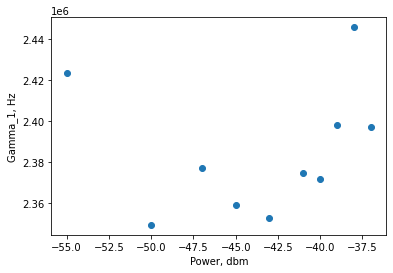

In [20]:
# plt.scatter(d.power[11:-2], d.ig.gamma1[11:-2])
plt.xlabel('Power, dbm')
plt.ylabel('Gamma_1, Hz')
plt.scatter(d.power[1:], d.ig.gamma1[1:])

In [21]:
8/235, 500/12000

(0.03404255319148936, 0.041666666666666664)

[458375648237.71704, 6.01716431282486e+16] [6.06393071e+16 8.08359955e+10]


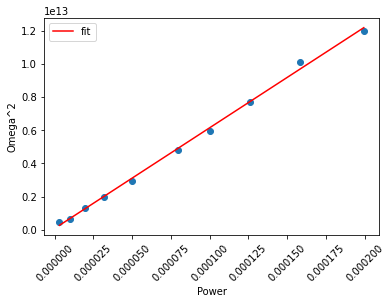

In [22]:
# plt.scatter(10.**(0.1*d.power[11:-2]), d.ig.omega[11:-2])4
def linear(x, a, b): return a*x + b
plt.xlabel('Power')
plt.ylabel('Omega^2')
x, y = 10.**(0.1*d.power[1:]), d.ig.omega[1:]
# x, y = 10.**(0.1*d.power[11:-2]), d.ig.omega[11:-2]*d.ig.gamma1[11:-2]*d.ig.gamma2[11:-2]
# x, y = (d.power[11:-2]), d.ig.omega[11:-2]*d.ig.gamma1[11:-2]*d.ig.gamma2[11:-2]
plt.scatter(x, y)
popt, pcov = curve_fit(linear, x, y, p0=[y[0], y[-1]/x[-1]])
print([y[0], y[-1]/x[-1]], popt)
plt.plot(x, linear(x, *popt), label='fit', c='r')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [23]:
250/1750

0.14285714285714285

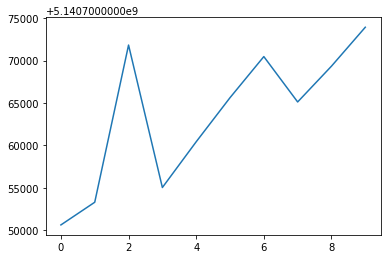

In [217]:
plt.plot(d.ig.freq_r[1:])

In [218]:
25/5.14e9

4.863813229571985e-09